## Homework №3

Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.


#### imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

import scipy.stats as sps



### 1. 
Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.


In [2]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))

players = pickle.load(open('data/players.pkl', 'rb'))
players_df = pd.DataFrame.from_dict(players, orient='index')
with open('data/players_df.pkl', 'wb') as f:
    pickle.dump(players_df, f)   
    
    
year_train_start = 2019
year_validation_start = 2020

data = []
for tournament_num in tqdm(tournaments.keys()):
        if results[tournament_num] != []:      
            year = int(tournaments[tournament_num]['dateStart'].split('-')[0])
            if year in [year_train_start, year_validation_start]:
                for team in results[tournament_num]:
                    if not team.get('mask') is None:
                        if not '?' in team.get('mask') and not 'X' in team['mask']:
                            for i, answer in enumerate(team['mask']):
                                question_id = tournament_num*100000 + i
                                for member in team['teamMembers']:
                                    question_data = dict()
                                    question_data['answer'] = int(answer)
                                    question_data['question_id'] = question_id
                                    question_data['year'] = year
                                    question_data['team_id'] = tournaments[tournament_num]['id']
                                    question_data['player_id'] = member['player']['id']

                                    data.append(question_data)
df = pd.DataFrame.from_dict(data)

df = pd.merge(df, players_df, left_on=['player_id'], right_on=['id'])
with open('data/df.pkl', 'wb') as f:
    pickle.dump(df, f) 
    
    
train = df[df['year'] == year_train_start]
val = df[df['year'] == year_validation_start]
train = pd.merge(train, players_df, left_on=['player_id'], right_on=['id'])
val = pd.merge(val, players_df, left_on=['player_id'], right_on=['id'])



with open('data/train_questions.pkl', 'wb') as f:
    pickle.dump(train, f)
with open('data/val_questions.pkl', 'wb') as f:
    pickle.dump(val, f)
with open('data/df.pkl', 'wb') as f:
    pickle.dump(df, f)


100%|██████████| 5528/5528 [00:28<00:00, 195.83it/s]  


In [3]:
df = pickle.load(open('data/df.pkl', 'rb'))
train = pickle.load(open('data/train_questions.pkl', 'rb'))
val = pickle.load(open('data/val_questions.pkl', 'rb'))

### 2. 
Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; 
* скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


Предположения:
* Если команда ответила на вопрос, значит каждый игрок взял этот вопрос. 
* Сделаем сильное предположение что сложность вопроса не зависит от турнира, а только от того доли команд, которые ответили на него верно. Сделав это предположение мы не учитываем силу команд и сложность турниров, но получаем легко вычислимую и интерпритируемую величину сложности вопроса.
* Ответ будем предсказывать логистической регрессией по сложности вопроса своей моделью для каждого игрока.
* Рейтинг игрока - взвещенная (на сложности вопросов) сумма его ответов на вопросы всех сложностей, - численная апроксимация интеграла для вычисления матожидания ответа на вопрос.

In [4]:
# Calculate uestion difficulty
def calculate_question_diff(df):
    
    question_scores = df.groupby(['question_id'])['answer'].agg('sum')
    question_count = df.groupby(['question_id'])['answer'].agg('count')
    difficulty_of_questions = question_scores.div(question_count);
    df = pd.merge(df, difficulty_of_questions, on=['question_id'])
    df.rename(columns={'answer_y':'question_difficulty'}, inplace=True)
    df.rename(columns={'answer_x':'answer'}, inplace=True)
    return df

df = calculate_question_diff(df)

with open('data/df_questions_with_diff.pkl', 'wb') as f:
        pickle.dump(df, f)

In [5]:
df = pickle.load(open('data/df_questions_with_diff.pkl', 'rb'))

In [6]:
df.head(5)

,answer,question_id,year,team_id,player_id,id,name,patronymic,surname,question_difficulty
0,1,477200000,2019,4772,6212,6212,Юрий,Яковлевич,Выменец,0.892295
1,1,477200000,2019,4772,18332,18332,Александр,Витальевич,Либер,0.892295
2,1,477200000,2019,4772,18036,18036,Михаил,Ильич,Левандовский,0.892295
3,1,477200000,2019,4772,22799,22799,Сергей,Игоревич,Николенко,0.892295
4,1,477200000,2019,4772,15456,15456,Сергей,Владимирович,Коновалов,0.892295


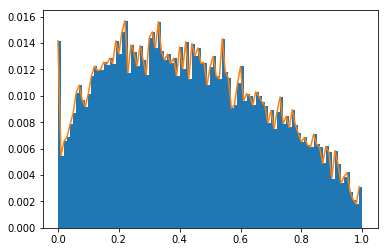

In [7]:
# get normalized distribution of difficulties
diffs = df['question_difficulty'].tolist()
weights = np.ones_like(diffs)/float(len(diffs))
normalised_distribution = plt.hist(diffs, weights=weights, bins = 100)
plt.plot(normalised_distribution[1][0:100],normalised_distribution[0])

In [9]:
df['player_rating'] = None
players = df['player_id'].unique().tolist()
players_data = []
for player in tqdm(players):
    players_data.append((player, df[df['player_id'] == player][['question_difficulty','answer']]))

100%|██████████| 61711/61711 [24:45<00:00, 41.53it/s]


In [18]:
rates = []
for player_data in tqdm(players_data):
    player_model = LogisticRegression(solver='lbfgs')
    try:
        player_model.fit(player_data[1][['question_difficulty']], player_data[1]['answer'])
        rates.append((player_data[0], np.dot(player_model.predict_proba([[i] for i in normalised_distribution[1][0:100]])[:, 1],
                     normalised_distribution[0])))
    except:
        rates.append((player_data[0],player_data[1]['answer'][0]))



  0%|          | 0/61711 [00:00<?, ?it/s]

  0%|          | 12/61711 [00:00<08:44, 117.75it/s]

  0%|          | 26/61711 [00:00<08:21, 122.93it/s]

  0%|          | 35/61711 [00:00<09:16, 110.73it/s]

  0%|          | 45/61711 [00:00<09:39, 106.44it/s]

  0%|          | 58/61711 [00:00<09:23, 109.32it/s]

  0%|          | 70/61711 [00:00<09:14, 111.22it/s]

  0%|          | 80/61711 [00:00<10:00, 102.67it/s]

  0%|          | 93/61711 [00:00<09:30, 108.04it/s]

  0%|          | 104/61711 [00:00<09:32, 107.67it/s]

  0%|          | 115/61711 [00:01<10:17, 99.76it/s] 

  0%|          | 125/61711 [00:01<10:53, 94.22it/s]

  0%|          | 143/61711 [00:01<09:23, 109.33it/s]

  0%|          | 155/61711 [00:01<09:08, 112.15it/s]

  0%|          | 167/61711 [00:01<09:00, 113.85it/s]

  0%|          | 179/61711 [00:01<09:21, 109.68it/s]

  0%|          | 191/61711 [00:01<10:23, 98.67it/s] 

  0%|          | 204/61711 [00:01<09:48, 104.60it/s]

  0%|          | 215/61711 [00:01<10:16, 99.73

In [ ]:
for player_rate in tqdm(rates):
    df[df['player_id']==player_rate[0]]['player_rating'] = player_rate[1]
df= df[['player_id', 'question_id', 'answer', 'question_difficulty', 'player_rating']]
with open('data/df_baseline_rating.pkl', 'wb') as f:
    pickle.dump(df, f)

In [2]:
df = pickle.load(open('data/df_baseline_rating.pkl', 'rb'))

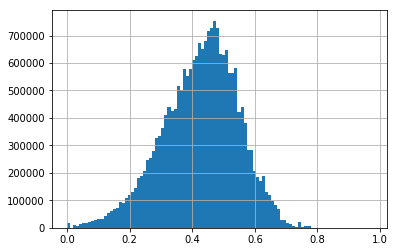

In [3]:
df['player_rating'].hist(bins=100)

In [22]:
players = pickle.load(open('data/players.pkl', 'rb'))
players_df = pd.DataFrame.from_dict(players, orient='index')

In [23]:
palyers = df[['player_id', 'player_rating']].drop_duplicates()
top_players = palyers.sort_values('player_rating', ascending=False).head(10)
top_players = pd.merge(top_players, players_df, left_on=['player_id'], right_on=['id'])
top_players[['name','surname','player_rating']]

,name,surname,player_rating
0,Павел,Щербина,0.972257
1,София,Лебедева,0.914663
2,Михаил,Завьялов,0.901762
3,Давид,Кан,0.901762
4,Екатерина,Горелова,0.857715
5,Наталья,Артемьева,0.857715
6,Юлия,Крюкова,0.857715
7,Полина,Джегур,0.850784
8,Елизавета,Коваленко,0.850784
9,Арина,Гринко,0.818928


Здесь так же присутсвуют игроки, у которых мало игр. В идеале мы должны считать достоверный рейтинг только игроков с достаточно большим числом игр. 

### 3.
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


In [7]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
tournaments_df = pd.DataFrame.from_dict(tournaments, orient='index')
tournaments_df['year'] = tournaments_df['dateStart'].apply(lambda x: int(x.split('-')[0]))
tournaments_val = tournaments_df[tournaments_df['year']==2020]

In [52]:
rated_players = palyers['player_id'].tolist()
results = pickle.load(open('data/results.pkl', 'rb'))
spearmans = []
kendalls =[]

for tournament_id in tqdm(tournaments_val['id'].tolist()):
    if  results[tournament_id]:
        if 'position' in results[tournament_id][0].keys():
            true_team_ranks=[]
            predicted_team_ranks=[]

            for _, team in enumerate(results[tournament_id]):
                true_team_ranks.append(team['position'])

                prob_to_answer_wrong = 1
                for player in team['teamMembers']:
                    player_id = player['player']['id'] 
                    if player_id in rated_players:
                        player_rating = palyers[palyers['player_id'] == player_id]['player_rating'].tolist()[0]
                    else:
                        player_rating = palyers['player_rating'].mean()
                    prob_to_answer_wrong *= (1 - player_rating)
                predicted_team_ranks.append(1 - prob_to_answer_wrong)
                               
                
            spearman = sps.spearmanr(np.asarray(predicted_team_ranks), -np.asarray(true_team_ranks))[0]
            kendall = sps.kendalltau(np.asarray(predicted_team_ranks), -np.asarray(true_team_ranks))[0]       
            spearmans.append(spearman)
            kendalls.append(kendall)
            
spearmans = [i for i in spearmans if not i!=i]
kendalls = [i for i in kendalls if not i!=i]

print('Mean Spearman: ',sum(spearmans)/len(spearmans))
print('Mean Kendalltau: ',sum(kendalls)/len(kendalls))




  0%|          | 0/418 [00:00<?, ?it/s]


  0%|          | 2/418 [00:00<02:17,  3.03it/s]


  1%|          | 4/418 [00:02<03:10,  2.17it/s]


  1%|          | 5/418 [00:02<03:47,  1.82it/s]


  2%|▏         | 9/418 [00:05<04:01,  1.69it/s]


  2%|▏         | 10/418 [00:07<05:51,  1.16it/s]


  3%|▎         | 11/418 [00:09<09:10,  1.35s/it]


  3%|▎         | 12/418 [00:11<10:15,  1.52s/it]


  3%|▎         | 13/418 [00:12<08:48,  1.30s/it]


  3%|▎         | 14/418 [00:13<08:29,  1.26s/it]


  4%|▎         | 15/418 [00:14<06:49,  1.02s/it]


  4%|▍         | 16/418 [00:15<07:05,  1.06s/it]


  5%|▍         | 20/418 [00:20<07:31,  1.14s/it]


  5%|▌         | 21/418 [00:24<12:47,  1.93s/it]


  5%|▌         | 22/418 [00:26<14:18,  2.17s/it]


  6%|▌         | 23/418 [00:28<12:07,  1.84s/it]


  6%|▌         | 24/418 [00:30<13:15,  2.02s/it]


  6%|▋         | 27/418 [00:30<09:17,  1.43s/it]


  7%|▋         | 29/418 [00:37<13:26,  2.07s/it]


  7%|▋         | 30/418 [00:44<22:09,  3.

Mean Spearman:  0.6672880916086193
Mean Kendalltau:  0.5154203218219203


In [53]:
print('Mean Spearman: ',sum(spearmans)/len(spearmans))
print('Mean Kendalltau: ',sum(kendalls)/len(kendalls))

Mean Spearman:  0.6672880916086193
Mean Kendalltau:  0.5154203218219203


## 4.

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков;
* скорее всего, понадобятся скрытые переменные; 
* не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Будем использовать скрытую переменную, означающую какие из игроков затащили вопрос (1, 1, 0, 0, 0, 1)

На M-шаге максимизируем правдоподобие скрытой переменной (0.1, 0.3, 0.5, 0,1, 0)- того, что именно этот игрок затащил вопрос по его командам и их ответам.

На Е-шаге мы обучаем модель регрессии, предсказывающей вероятность игрока взять вопрос в зависимости от вопроса и игрока. "Сила" игрока и сложность вопроса - обучаемые веса нашей модели.



In [2]:
df = pickle.load(open('data/df.pkl', 'rb'))

In [4]:
#one-hot encode indexes of player and question 
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df[['player_id', 'question_id']])
sparce_matrix = encoder.transform(df[['player_id', 'question_id']])
counts = np.array((sparce_matrix != 0).sum(axis=0)).ravel()

#weights = "force" of player and difficulty of questions
weights = np.random.randn(sparce_matrix.shape[1])
p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(weights))) 

#construct data for E-step
df['negative_player_answer_prob'] = 1 - p_player_to_answer
m_df = df[['team_id', 'question_id', 'negative_player_answer_prob']].groupby(by=['team_id', 'question_id'], sort=False, as_index=False).prod()
from_id = (m_df['team_id'].apply(str) + m_df['question_id'].apply(str)).apply(int)
to_id = (df['team_id'].apply(str) + df['question_id'].apply(str)).apply(int)

In [8]:
def E_step(p_player_to_answer):
    df['negative_player_answer_prob'] = 1 - p_player_to_answer
    prods = df[['team_id', 'question_id', 'negative_player_answer_prob']].groupby(by=['team_id', 'question_id'], sort=False, as_index=False).prod()['negative_player_answer_prob']
    prods.index = from_id
    prods = prods[to_id].to_numpy()
    hidden = p_player_to_answer / (1 - prods)
    hidden[df['answer'] == 0] = 0
    return hidden

def M_step(sparce_matrix, weights, hidden, iterations=30, alpha=2):
    weights = weights.copy()
    for i in range(iterations):
        p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(weights)))
        #weights optimization step
        weights = weights + alpha * ((sparce_matrix.T).dot(hidden * (1 - p_player_to_answer) - (1 - hidden) * p_player_to_answer) / counts)
    return weights

def likelihood(hidden, sparce_matrix, weights):
    p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(weights)))
    return np.mean(hidden * np.log(p_player_to_answer) + (1 - hidden) * np.log(1 - p_player_to_answer))

In [9]:
iterations = 10
for i in tqdm(range(iterations)):
    if i == 0:
        p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(weights)))
        hidden = E_step(p_player_to_answer)
    weights = M_step(sparce_matrix, weights, hidden)
    p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(weights)))
    hidden = E_step(p_player_to_answer)
    print('Iteration: ', i)
    print('Log likelihood: :', likelihood(hidden, sparce_matrix, weights))
    print('\n')

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration:  0


 10%|█         | 1/10 [00:41<06:14, 41.63s/it]

Log likelihood: : -0.32131073511835934


Iteration:  1


 20%|██        | 2/10 [01:18<05:22, 40.28s/it]

Log likelihood: : -0.22728705054941084


Iteration:  2


 30%|███       | 3/10 [01:56<04:36, 39.48s/it]

Log likelihood: : -0.17902747443623437


Iteration:  3


 40%|████      | 4/10 [02:33<03:52, 38.68s/it]

Log likelihood: : -0.14900367960558153


Iteration:  4


 50%|█████     | 5/10 [03:11<03:12, 38.49s/it]

Log likelihood: : -0.1283896056556358


Iteration:  5


 60%|██████    | 6/10 [03:49<02:33, 38.39s/it]

Log likelihood: : -0.11331183638858337


Iteration:  6


 70%|███████   | 7/10 [04:27<01:54, 38.30s/it]

Log likelihood: : -0.10177794390029636


Iteration:  7


 80%|████████  | 8/10 [05:04<01:16, 38.01s/it]

Log likelihood: : -0.0926534041677791


Iteration:  8


 90%|█████████ | 9/10 [05:42<00:37, 37.89s/it]

Log likelihood: : -0.08524427806744683


Iteration:  9


100%|██████████| 10/10 [06:21<00:00, 38.16s/it]

Log likelihood: : -0.07910221058578717




In [11]:
# get weights of model - force of players and difficulty of questions
idx_to_position = {}
for i, fname in enumerate(encoder.get_feature_names()):
    idx_to_position[int(fname[3:])] = i

player_force = pd.Series(np.zeros(len(df['player_id'].unique())),
                  df['player_id'].unique())
for player in df['player_id'].unique():
    player_force[player] = weights[idx_to_position[player]]


questtion_diff = pd.Series(np.zeros(len(df['question_id'].unique())),
                      df['question_id'].unique())
for question in df['question_id'].unique():
    questtion_diff[question] = weights[idx_to_position[question]]

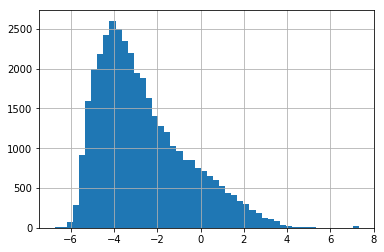

In [12]:
questtion_diff.hist(bins=50)

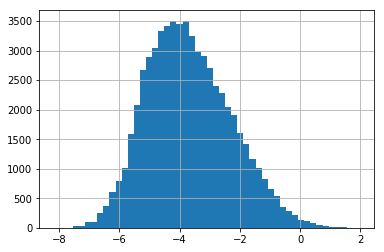

In [13]:
player_force.hist(bins=50)

## 5.

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).